# [Netflix Rating Prediction - 4]

Group Members:

Rekin Barışıcı 26399

Oğuz Kağan Yur 26445

Tahir Turgut 27035

Emir Arif Çankaya 26555

## Introduction

While we were choosing the dataset & problem, we were considering the most suitable way to fully use things that we covered in CS210 course. So that we picked the Netflix dataset and Prediction problem. We plan to combine these datasets and implement it in our machine learning methods to come up with a prediction, which will allow us to fully use our knowledge and push us to explore more data science aspects.


### Problem Definition


Online movie streaming platforms such as Netflix shows inaccurate ratings or does not show any rating information about movies at all. We aim to collect related datasets about movies for instance; title, country, release year, duration, description, age rating... after receiving these datasets; firstly we will be labeling these datas to analyse and observe before applying, secondly we aim to find a rating using KNN method and without using release year information. After adding release year data to our calculation, result will prove the data's value. Furthermore, we plan to use additional method which is random forest and by implementing this we will compare which machine learning method is suitable for our project.

### Utilized Datasets


Netflix Movies and TV Shows (www.kaggle.com/shivamb/netflix-shows): main dataset to create a movie recommendation for user, with columns of:



> Unique ID for every Movie / Tv Show, string
> Identifier - A Movie or TV Show, string

Title of the Movie / Tv Show, string

Director of the Movie, string

Actors involved in the movie / show, string

Country where the movie / show was produced, string

Date it was added on Netflix, DateTime

Actual Release year of the move / show, integer

TV Rating of the movie / show, string

Total Duration - in minutes or number of seasons, string



IMDb movies extensive dataset (https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset?select=IMDb+ratings.csv): is used by getting weigthed average rating of each movie in dataset "Netflix Movies and TV Shows". Only the file of "IMDb ratings.csv" and "IMDb movies.csv" is used. Movie name's are derived from "IMDb movies.csv" and their respective weigthed average rating (in decimals) is derived from "IMDb ratings.csv".



## Data Exploration


In [ ]:
from google.colab import drive
from os.path import join
import matplotlib.pyplot as plt

drive.mount('./drive')
path_prefix = "./drive/MyDrive"

Mounted at ./drive


In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

main = pd.read_csv(join(path_prefix, "netflix_titles.csv"))
movies = pd.read_csv(join(path_prefix, "movies.csv"))
ratings = pd.read_csv(join(path_prefix, "ratings.csv"))
scores=[]

#deleting Tv Series since we only use Movies
index_names = main[ main['type'] == "TV Show"].index 
main.drop(index_names, inplace = True) 

#deleting not used data
main=main.drop(["type","date_added"],axis=1)

#combining two datasets
for element in main["title"]:
  index=movies[movies["title"] == element].index;
  if len(index) !=0:
    scores.append(ratings["weighted_average_vote"][index[0]])
  else:
    scores.append(5)
      
main["scores"]=scores
main.head(5)



,show_id,title,director,cast,country,release_year,rating,duration,listed_in,description,scores
0,81145628,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,3.2
1,80117401,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,5.0
4,80125979,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,5.0
6,70304989,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada",2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",6.1
7,80164077,Fabrizio Copano: Solo pienso en mi,"Rodrigo Toro, Francisco Schultz",Fabrizio Copano,Chile,2017,TV-MA,60 min,Stand-Up Comedy,Fabrizio Copano takes audience participation t...,5.0



The goal of that chart is to observe how rating column intensely distributed. We came to conclusion that that ratings can be grouped by biggest 6 one and classified the rest as 'others' 



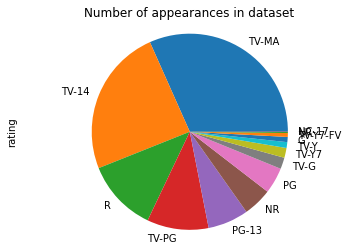

In [ ]:
#pie chart of appearances of ratings
main.rating.value_counts().plot(kind='pie')     #take the counts of every rating type
plt.axis('equal')
plt.title('Number of appearances in dataset')
plt.show()


This graph is representing the categories of movies with higher than 100 instances. We conclude that the category distrubiton is enough to vectorize them and use them in to k means technique 


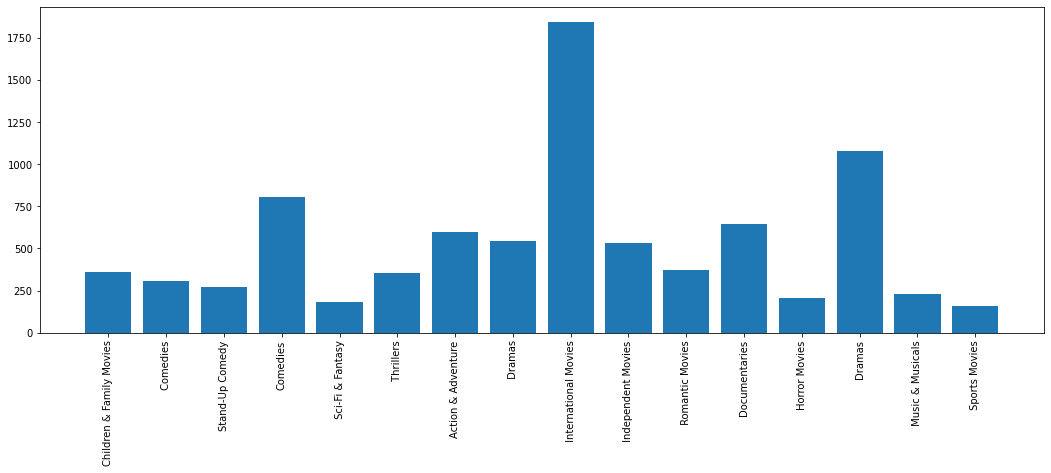

In [ ]:
categories = {}         #dictionary to take count of every category
for index, row in main.iterrows():
  listt = row["listed_in"].split(",")
  for category in listt:
    if not category in categories:
      categories[category] = 1
    else:
      categories[category] += 1

#if there is less than 100 instances do not display those
categories = dict(filter(lambda elem: elem[1] > 100, categories.items()))

#display the dictionaries' keys in x axis and values in y axis
fig, ax = plt.subplots(figsize=(18, 6))
fig = plt.bar(range(len(categories)), list(categories.values()), align='center')
plt.xticks(range(len(categories)), list(categories.keys()), rotation=90)

plt.show()


As seen in the graph, score information is not dependable, since we obtain it from another dataset with most of NaN values (filled with 5).


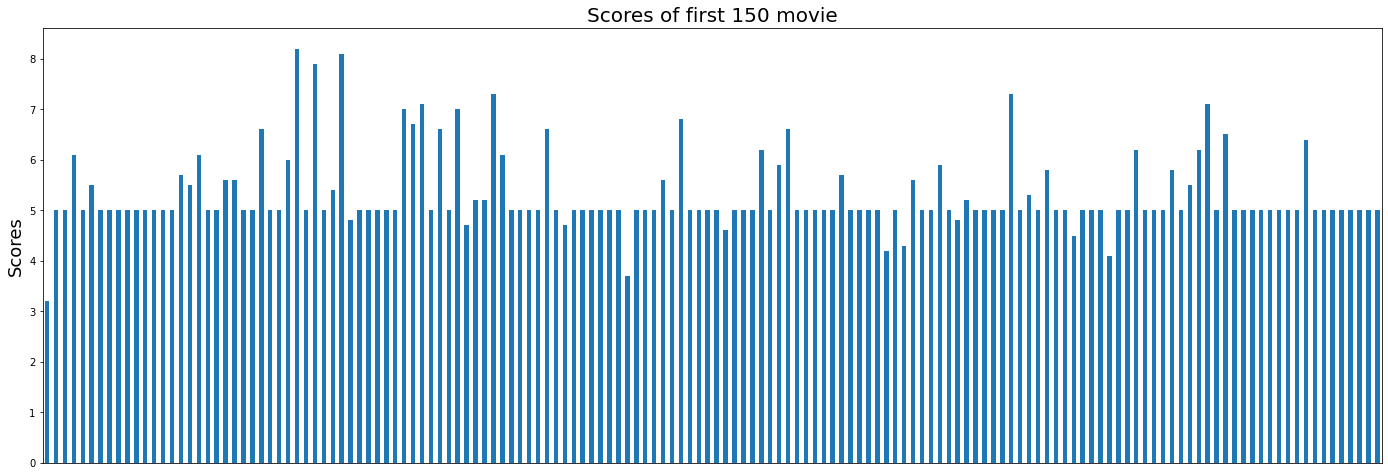

Mean of all scores is 5.373247362250867


In [ ]:
#score distribution of first 150 movies (among with non NaN scores)

main_temp = main
main_temp = main_temp["scores"].apply(pd.to_numeric, errors='coerce')
main_temp = main_temp.dropna()
meann = main_temp.mean()          #mean of all of the movies' scores (non NaN)
main_temp = main_temp[:150]       #filter the first 150, to display more intense graph

fig, ax = plt.subplots(figsize=(24,8))
main_temp.plot.bar()
plt.xticks([])
plt.title("Scores of first 150 movie", fontsize=20)
plt.ylabel("Scores", fontsize=18)
plt.show()
print("Mean of all scores is", meann)


We wanted to observe relation between directors and their "favorite" rating. We take the 10 directors with most films and displayed their films' rating distrubition. Conclusion was in some of the cases, director can relate with the ratings, so it is useful in technique.


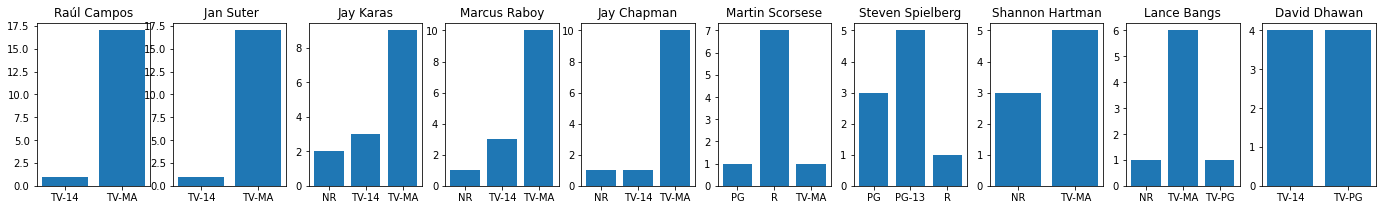

In [ ]:
#most occurred 10 director's rating distribution

dic={}
for index, row in main.iterrows():
  if isinstance(row["director"], str):          #if it is not NaN
    directors=row["director"].split(",")        #create a list from directors
    for director in directors:              #add every director to the dictionary
      if director in dic:
        dic[director].append(row["rating"])       #add every movie that s/he films
      else:
        dic[director]=[row["rating"]]

#show 10 directors with most films
fig, axes = plt.subplots(1, 10, figsize=(24,3))
for i in range(10):
  list_len = [len(value) for value in dic.values()]       
  keys_list = list(dic)
  keys_list[np.argmax(np.array(list_len))]

  #count of movie rating that s/he films by numpy unique function
  ratings, counts = np.unique(dic[keys_list[np.argmax(np.array(list_len))]], return_counts=True)
  foo = dic.pop(keys_list[np.argmax(np.array(list_len))])   #remove that director
  axes[i].bar(ratings, counts)
  axes[i].set_title(keys_list[np.argmax(np.array(list_len))])


Algorithm to label director, actors and categories. First in dictionaries, we create a label for each of them, then in a dataframe, we replace the labels with names to vectorize them.


In [ ]:
#take the first director and vectorize him/her
#if there is multiple directors, check the first(main) director and vectorize accordingly
directors = {}
for index, row in main.iterrows():
  if isinstance(row["director"], str):
    listt = row["director"].split(",")
    dir = listt[0]
    if not dir in directors:
      directors[dir] = len(directors)
    if not row["director"] in directors:
      directors[row["director"]] = directors[dir]


#take the first actor and vectorize him/her
#if there is multiple actors, check the first(main) actor and vectorize accordingly
actors = {}
for index, row in main.iterrows():
  if isinstance(row["cast"], str):
    listt = row["cast"].split(",")
    actor = listt[0]
    if not actor in actors:
      actors[actor] = len(actors)
    if not row["cast"] in actors:
      actors[row["cast"]] = actors[actor]


#vectorize any kind of category combination in the rows
cat = {}
for index, row in main.iterrows():
  if isinstance(row["listed_in"], str):
    #listt = row["listed_in"].split(",")
    #c = listt[0]
    if not row["listed_in"] in cat:
      cat[row["listed_in"]] = len(cat)


#replace the indices of ratings with their names, to be able to vectorize them
main_replaced = main.replace({"TV-MA": 0, "TV-14": 1, "R": 2, "TV-PG": 3, "PG-13": 4, "NR": 5,
    "PG": 6, "TV-G": 6, "TV-Y7": 6, "TV-Y": 6, "G": 6, "TV-Y7-FV": 6, "UR": 6, "NC-17": 6})

#drop the NaN values of in the columns to be used
main_replaced.dropna(how="any", inplace=True, subset=["rating"])
main_replaced.dropna(how="any", inplace=True, subset=["director"])
main_replaced.dropna(how="any", inplace=True, subset=["cast"])

#replace the vectorizable indices in the columns
main_replaced = main_replaced.replace(directors)
main_replaced = main_replaced.replace(actors)
main_replaced = main_replaced.replace(cat)
main_replaced.head()

,show_id,title,director,cast,country,release_year,rating,duration,listed_in,description,scores
0,81145628,Norm of the North: King Sized Adventure,0,0,"United States, India, South Korea, China",2019,3.0,90 min,0,Before planning an awesome wedding for his gra...,3.2
4,80125979,#realityhigh,2,3,United States,2017,1.0,99 min,2,When nerdy high schooler Dani finally attracts...,5.0
6,70304989,Automata,3,5,"Bulgaria, United States, Spain, Canada",2014,2.0,110 min,3,"In a dystopian future, an insurance adjuster f...",6.1
7,80164077,Fabrizio Copano: Solo pienso en mi,4,3157,Chile,2017,0.0,60 min,1,Fabrizio Copano takes audience participation t...,5.0
9,70304990,Good People,6,8,"United States, United Kingdom, Denmark, Sweden",2014,2.0,90 min,4,A struggling couple can't believe their luck w...,5.5


## Machine Learning Models

First, we tried our algorithm to recommend a movie to user without using machine learning. Later, we use KNN to predict the rating of movies with directors and cast given. 



### Implementation
We split the dataset into 4 parts (%80-training, %10-test, %10-validation) and used director, cast and release year to predict rating feature. Firstly, we applied k-NN technique to make prediction. In addition to that, we compared director and cast vs. director, cast, and release year. Release year’s effect was positive, so we move on with that additional feature. Secondly, we implemented Random Forest algorithm to the dataset. In comparison to k-NN, it has more accuracy rate. Finally, we tried hyper-parameter tunning to achieve more successful parameters in random forest. Then, we detect where is the mistake by confusion matrix of algorithms with and without cross validation.

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = main_replaced.drop("show_id", axis = 1)
X = X.drop(["title","country","release_year","duration","description","scores","rating"],axis = 1)

y = main_replaced["rating"]
# 80% for training and 20% for testing-validation
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.20, random_state=42)
# 10% validation, 10% test
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.50, random_state=42)

from sklearn.neighbors import KNeighborsClassifier

# create a new model with current K
knn = KNeighborsClassifier(6, metric="euclidean")
# fit training data
knn.fit(X_train, y_train)
# predict the validation data
y_pred = knn.predict(X_test)
# obtain the accuracy value
f"{accuracy_score(y_test, y_pred):.2f}"

print("So the right predictions without release year is {}".format(f"{accuracy_score(y_test, y_pred):.8f}"))


So the right predictions without release year is 0.32894737


In [ ]:
feed_data = main_replaced.drop("show_id", axis = 1)
feed_data = feed_data.drop(["title","country","duration","description","scores","rating"],axis = 1)#data with 3801 elements
print("Size of feed data:",len(feed_data))
results = main_replaced["rating"]

# 80% for training and 20% for testing-validation
X_train, X_remaining, y_train, y_remaining = train_test_split(feed_data, results, test_size=0.20, random_state=42)
print("Size of the train data:",len(X_train))

# 10% validation, 10% test
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.50, random_state=42)
print("Size of the test data:",len(X_test))
print("Size of the validation data:",len(X_val))

# create a new model with current K
knn = KNeighborsClassifier(6, metric="euclidean")
# fit training data
knn.fit(X_train, y_train)
# predict the validation data
y_pred = knn.predict(X_test)
# obtain the accuracy value
f"{accuracy_score(y_test, y_pred):.2f}"

print("So the right predictions for data with release year is {}".format(f"{accuracy_score(y_test, y_pred):.8f}"))


Size of feed data: 3801
Size of the train data: 3040
Size of the test data: 380
Size of the validation data: 381
So the right predictions for data with release year is 0.33947368


With releasing year accuracy increased to 0.33947368 from 0.32894737

Thus, we decide that adding country leads more proper prediction, so it should be in training dataset.

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_grid = GridSearchCV(estimator=KNeighborsClassifier() ,param_grid={'n_neighbors' : [4,5,6,7,8], 'weights':['uniform', 'distance'], 'metric':['euclidean' , 'manhattan']})
rf_grid.fit(X_train, y_train)
print("Here our best parameters",rf_grid.best_params_)
grid_preds = rf_grid.predict(X_test)
print("Accuracy score is:",accuracy_score(y_test, grid_preds))

Here our best parameters {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Accuracy score is: 0.37894736842105264


Accuracy of kNN with the GridSearch is ~0.379



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model_rf = RandomForestClassifier(criterion="entropy", random_state=42)
model_rf.fit(X_train, y_train)
rf_predictions = model_rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:{}".format(f"{rf_acc:.8f}"))

Random Forest Accuracy:0.41578947


Accuracy with Random Forest is ~ 0.415

On the other hand, accucary with k-NN technique with GridSearch is  ~ 0.379

Therefore, it can be concluded that Random Forest fits more to our problem solution.

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_grid = GridSearchCV(estimator=RandomForestClassifier(criterion='entropy') ,param_grid={"n_estimators" : [100,150,200], "min_samples_split":[4,8,12]})
rf_grid.fit(X_train, y_train)


print("Here our best parameters",rf_grid.best_params_)

grid_preds = rf_grid.predict(X_test)

print("Accuracy score is:",accuracy_score(y_test, grid_preds))

Here our best parameters {'min_samples_split': 12, 'n_estimators': 200}
Accuracy score is: 0.41842105263157897


### Results & Discussion

From our findings we can see that improvements has succeeded from each step to another. If we can do the same process with a more suitable dataset we can find a high success rate for predicting rating.
The methods we used fitted what we wanted to achieve. This results also shows that having 6 ratings to guess requires many features and a big dataset in order to have a high success rate. Besides that we conclude that 
there should be a balance while clearing dataset which; while dropping elements we should have enough numbers of elements and enough numbers of features at the same time. Also we concluded that using different machine learning algorithms
helps finding the best fitting one.

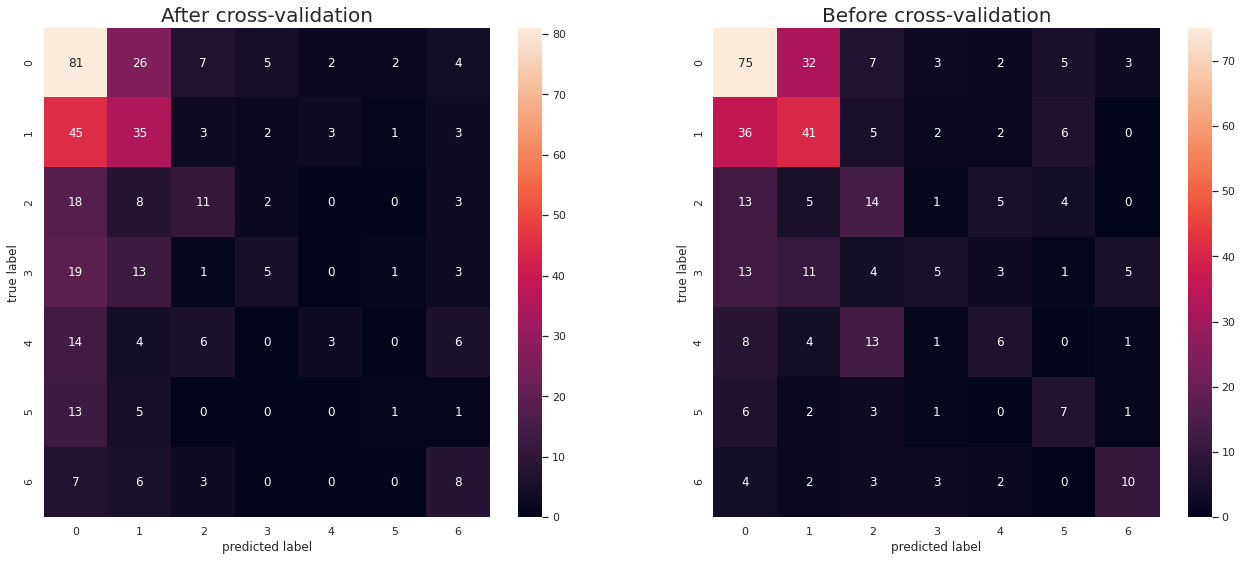

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(22,9))
sns.set()
mat = confusion_matrix(y_test, grid_preds)
sns.heatmap(mat, annot=True, fmt='d',ax=axes[0])
axes[0].set_title("After cross-validation",fontsize=20)
axes[0].set_xlabel('predicted label')
axes[0].set_ylabel('true label')

sns.set()
mat = confusion_matrix(y_test, rf_predictions)
sns.heatmap(mat, annot=True, fmt='d',ax=axes[1])
axes[1].set_title("Before cross-validation",fontsize=20)
axes[1].set_xlabel('predicted label')
axes[1].set_ylabel('true label')

plt.show()

In confusion matrix it can be observed that success rate of 0 is noticably higher than the total accuracy. In addition to that, false predictions are generally 0, as well. It may be caused by the high frequency of 0's in rating column (%33 of them).

## Conclusion

Here we tried to maximize our accuracy for our problem which is predicting rating, with adding new elements to data, clearing and editing data, using various machine learning models and grid-search algorithm. 
We succeeded in a sense that we started with 0.33 accuracy and increased that to 0.418. Eventhough we tried our best to find rating of a given movie inside our data we concluded that this dataset has no enough
aspects to let us achieve what we wanted to do(0.6~ success rate of predicting). So that adding more features(from other datasets maybe) or using a more crowded data set would increase our success rate..



## Future Work




For the future of this work, in order for it to be more useful and useable program it requires additional features to analyse datasets in order to calculate an accurate prediction. 


## Work Division



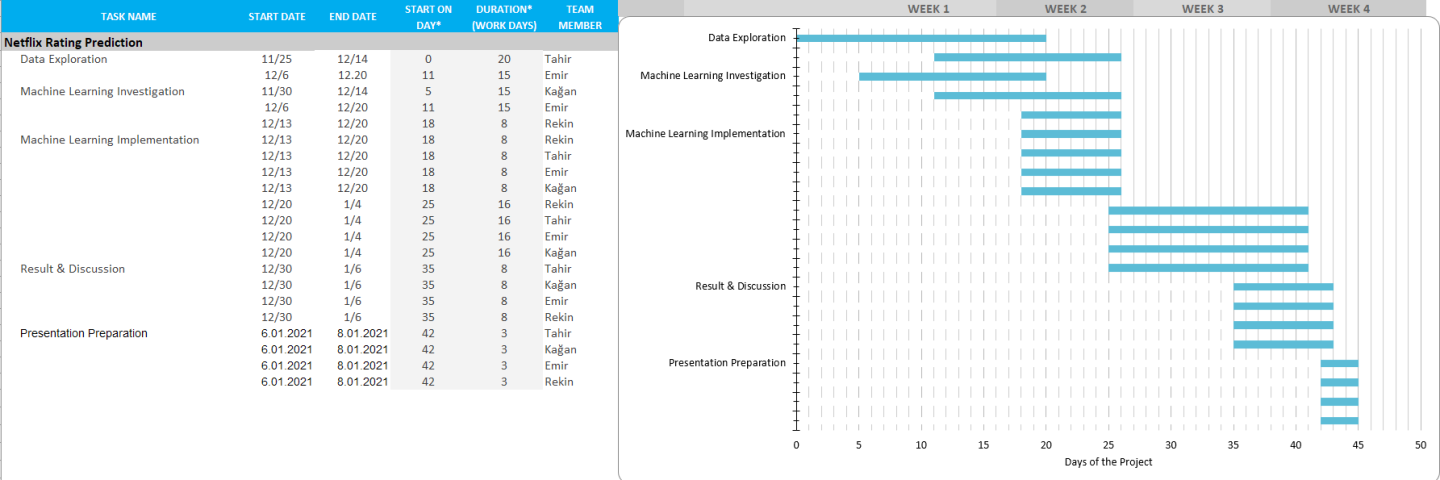